```
Time: ----[Training: 24 months]----[Test: 3 months]----[Training: 24 months]----[Test: 3 months]----
      2018              2020                2020.25            2022                2022.25
```

```
Data: 2018-2025 (7 years)
Training Start: 2018-2019 (first 24 months)
Backtest Period: 2020-2025 (5+ years out-of-sample)
Rebalancing: Quarterly (20+ rebalancing events)
```

Portfolio Universe: ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'META', 'NFLX', 'AMD', 'CRM']
Analysis Period: 2018-01-01 to 2025-07-20
FETCHING AND CLEANING DATA
Final universe: ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'META', 'MSFT', 'NFLX', 'NVDA', 'TSLA']
Data shape: (1896, 10)
Returns data shape: (1895, 10)
Date range: 2018-01-03 00:00:00 to 2025-07-18 00:00:00

WALK-FORWARD BACKTESTING
Walk-forward backtest period: 2019-03-31 00:00:00 to 2025-09-30 00:00:00
Number of rebalancing periods: 27
Using 24 months of history for each optimization
Optimizing for 2019-03-31 (1/27)
Optimizing for 2019-06-30 (2/27)
Optimizing for 2019-09-30 (3/27)
Optimizing for 2019-12-31 (4/27)
Optimizing for 2020-03-31 (5/27)
Optimizing for 2020-06-30 (6/27)
Optimizing for 2020-09-30 (7/27)
Optimizing for 2020-12-31 (8/27)
Optimizing for 2021-03-31 (9/27)
Optimizing for 2021-06-30 (10/27)
Optimizing for 2021-09-30 (11/27)
Optimizing for 2021-12-31 (12/27)
Optimizing for 2022-03-31 (13/27)
Optimizing fo

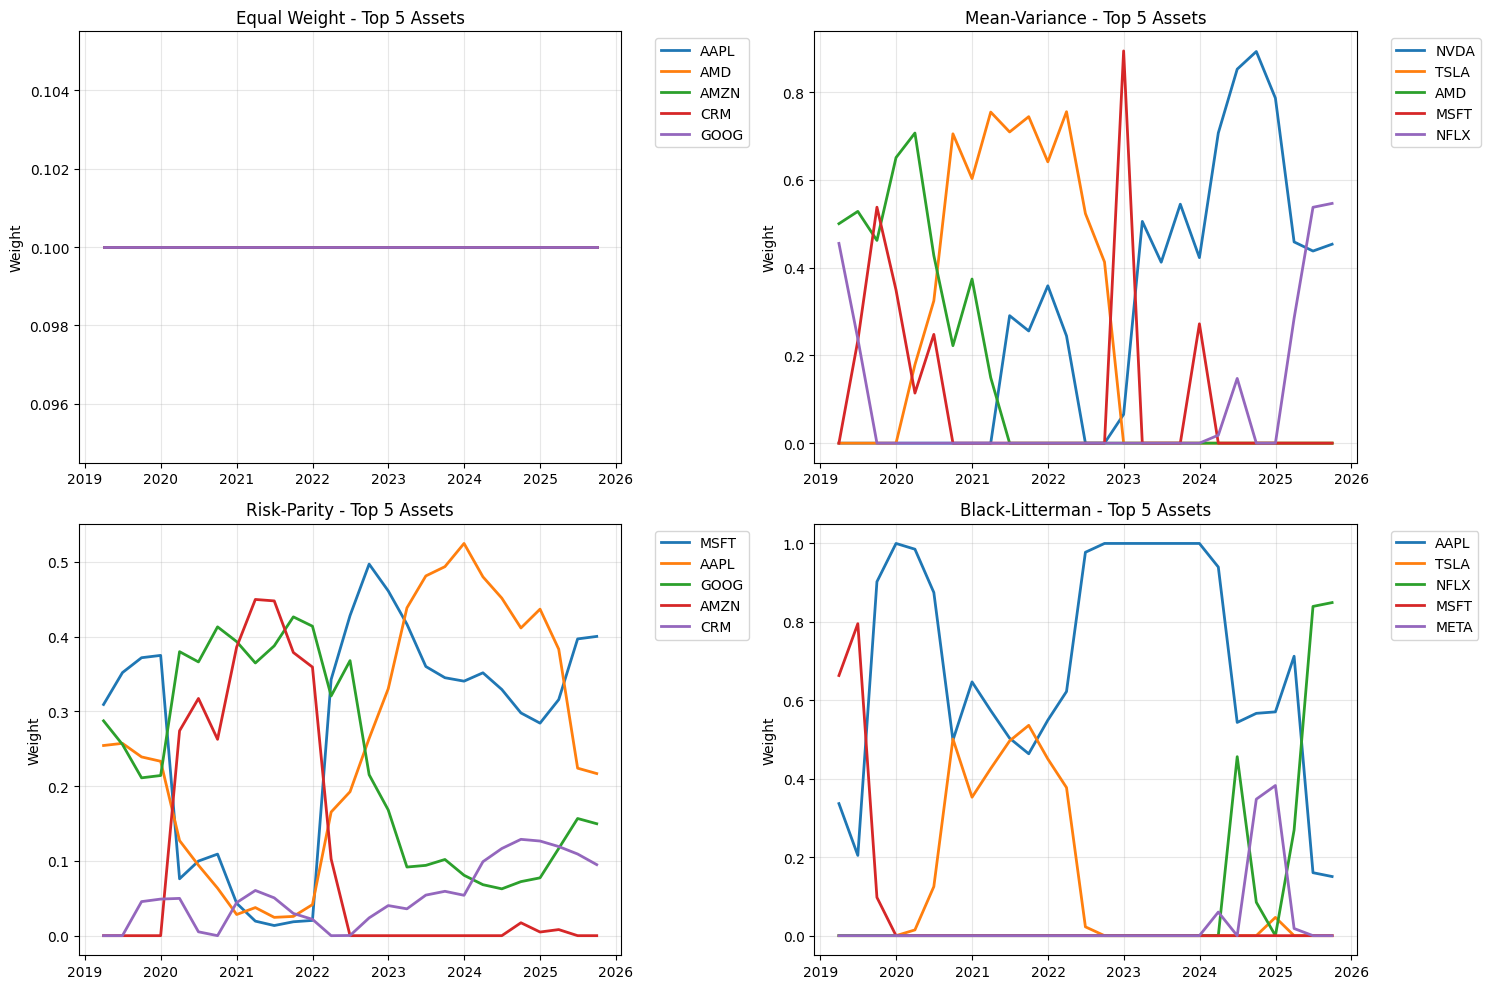

Plotting out-of-sample cumulative returns...


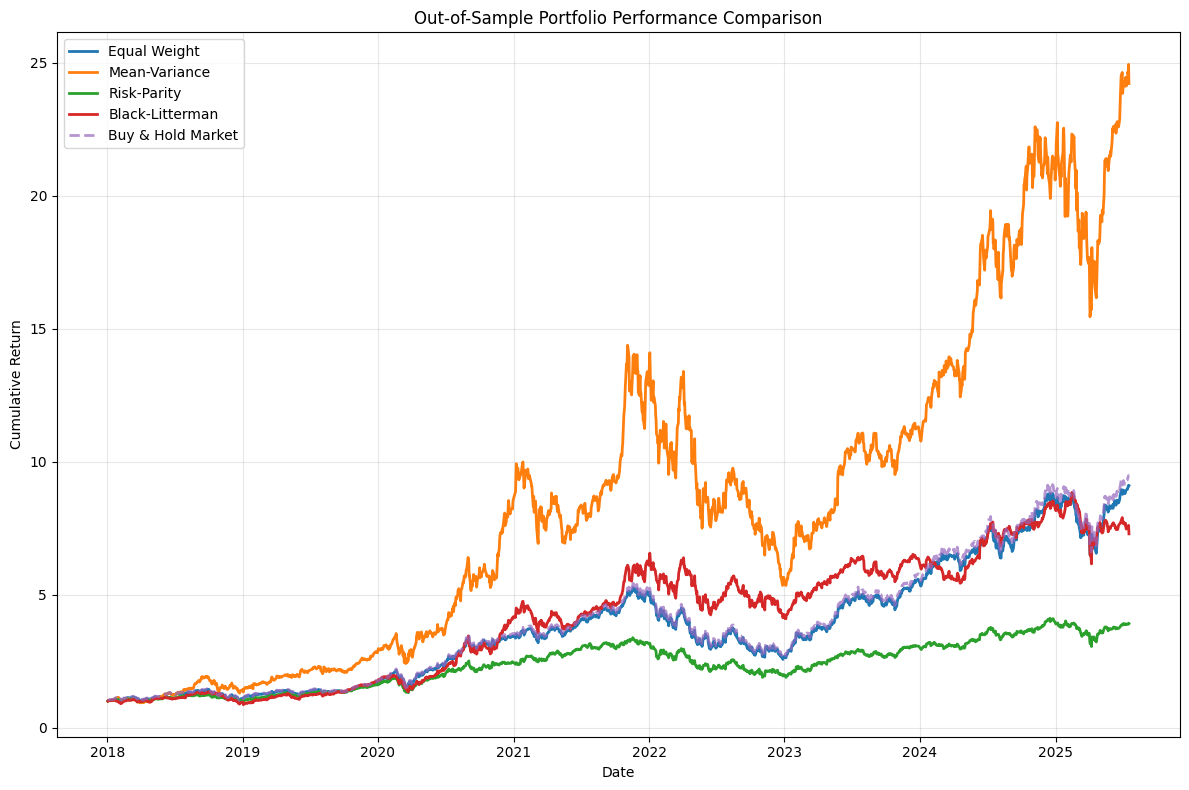

Plotting performance comparison...


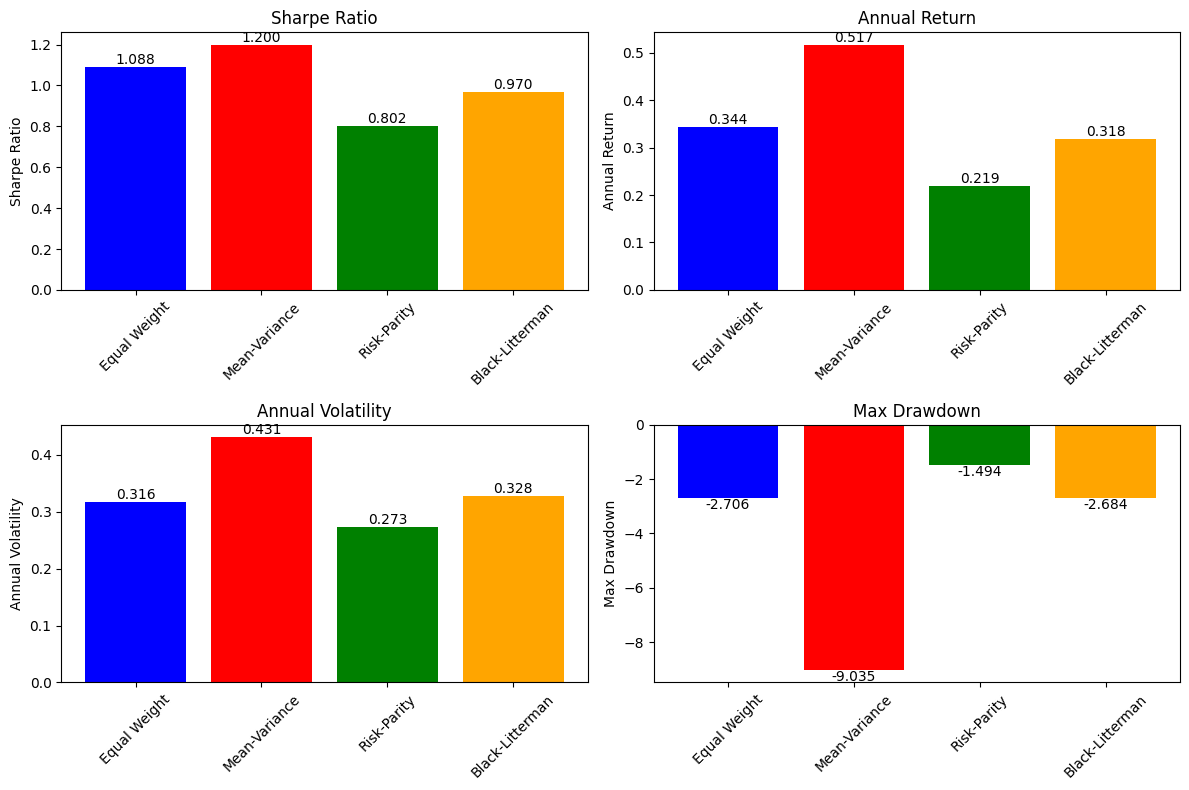

Detailed analysis for best performing strategy: Mean-Variance
Sharpe Ratio: 1.1996


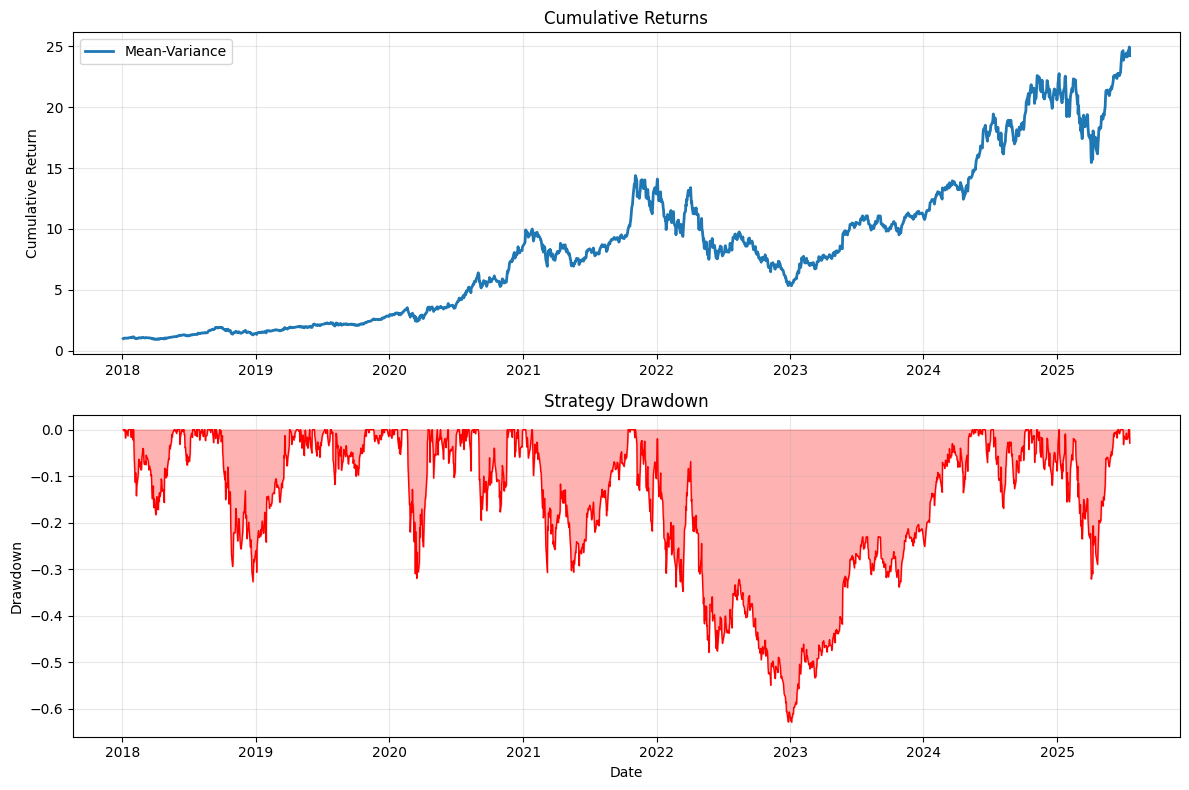

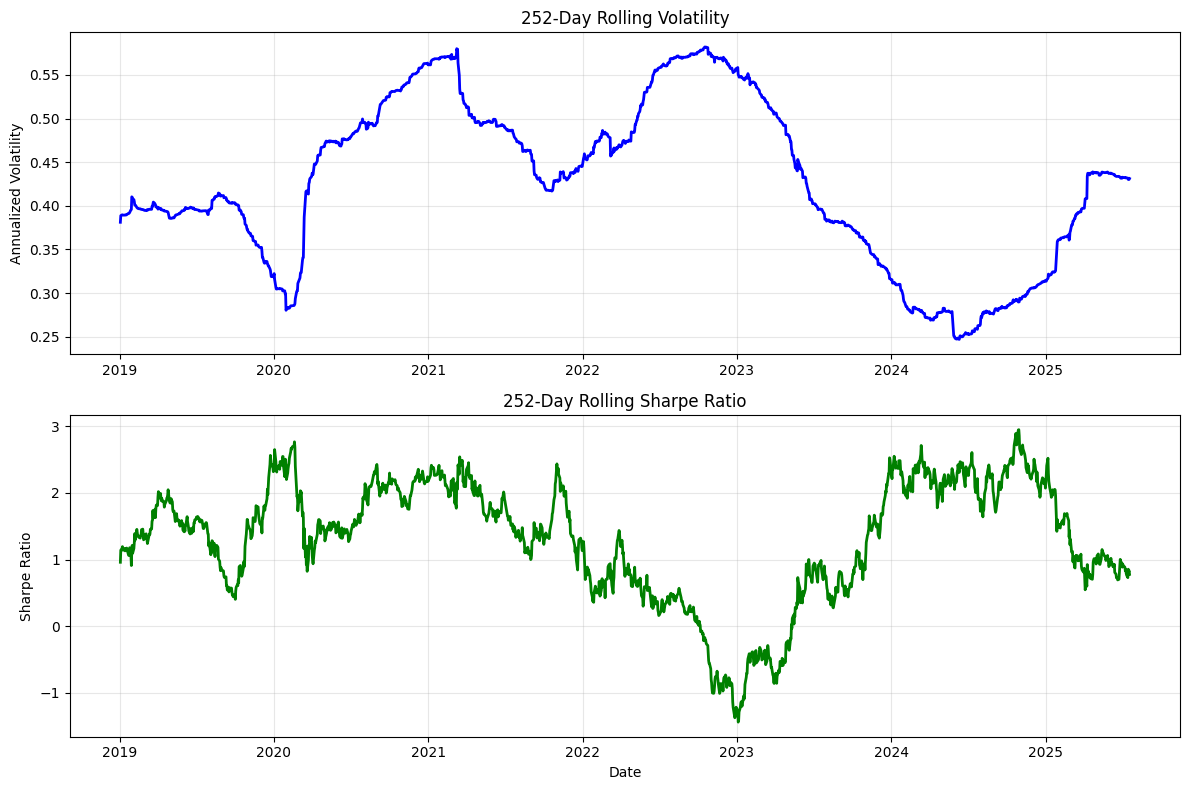


ANALYSIS COMPLETE!


In [5]:
# Integrated Portfolio Optimization Framework for Google Colab
# Install required packages first
# !pip install yfinance cvxpy scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.covariance import LedoitWolf
from datetime import datetime
import cvxpy as cp
import scipy.linalg as la
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. CONFIGURATION
# =============================================================================

# Example universe and date range
TICKERS = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'META', 'NFLX', 'AMD', 'CRM']
START_DATE = '2018-01-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')

# EWMA decay factor for return & cov
EWMA_LAMBDA = 0.94

print(f"Portfolio Universe: {TICKERS}")
print(f"Analysis Period: {START_DATE} to {END_DATE}")

# =============================================================================
# 2. DATA INGESTION & CLEANING
# =============================================================================

def fetch_price_data(tickers, start, end):
    """Download daily adjusted close prices from Yahoo Finance."""
    try:
        df = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False)['Adj Close']
        if len(tickers) == 1:
            df = df.to_frame()
            df.columns = tickers
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

def clean_and_align(df):
    """Clean and align price data."""
    # Forward-fill then backward-fill
    df = df.ffill().bfill()
    # Drop if too many missing originally
    na_frac = df.isna().mean()
    drop = na_frac[na_frac > 0.05].index
    if len(drop) > 0:
        print(f"Dropping assets with >5% missing data: {drop.tolist()}")
        df = df.drop(columns=drop)
    return df

# =============================================================================
# 3. RETURN CALCULATIONS
# =============================================================================

def compute_simple_returns(prices):
    """Compute simple returns: r_t = P_t / P_{t-1} - 1"""
    return prices.pct_change().dropna()

def compute_log_returns(prices):
    """Compute log returns: r_t = ln(P_t / P_{t-1})"""
    return np.log(prices / prices.shift(1)).dropna()

def ewma_mean(returns, lam=EWMA_LAMBDA):
    """Exponentially‐weighted moving average of past returns."""
    weights = (1 - lam) * lam ** np.arange(len(returns)-1, -1, -1)
    weights /= weights.sum()
    return returns.mul(weights, axis=0).sum()

# =============================================================================
# 4. RISK ESTIMATORS
# =============================================================================

def sample_covariance(returns):
    """Unbiased sample covariance matrix estimator."""
    return returns.cov()

def ewma_covariance(returns, lam=EWMA_LAMBDA):
    """Exponential‐weighted covariance matrix."""
    n_assets = len(returns.columns)
    S = np.eye(n_assets) * 0.01  # Initialize with small diagonal matrix

    for t in range(len(returns)):
        r = returns.iloc[t].values.reshape(-1, 1)
        if t == 0:
            S = r @ r.T
        else:
            S = lam * S + (1 - lam) * (r @ r.T)

    return pd.DataFrame(S, index=returns.columns, columns=returns.columns)

def ledoit_wolf_covariance(returns):
    """Ledoit–Wolf shrinkage estimator from sklearn."""
    lw = LedoitWolf().fit(returns.values)
    return pd.DataFrame(lw.covariance_,
                        index=returns.columns,
                        columns=returns.columns)

# =============================================================================
# 5. PORTFOLIO OPTIMIZATION
# =============================================================================

def regularize_covariance(Sigma, eps=1e-6):
    """Add eps*I to Sigma to ensure it's positive‑definite."""
    n = Sigma.shape[0]
    return Sigma + eps * np.eye(n)

def optimize_mean_variance(mu, Sigma, lam, weight_bounds=(0, 1)):
    """Mean-variance optimization using CVXPY."""
    n = len(mu)
    w = cp.Variable(n)
    Sigma_reg = regularize_covariance(Sigma.values if hasattr(Sigma, 'values') else Sigma)

    obj = cp.Maximize(mu @ w - (lam/2) * cp.quad_form(w, Sigma_reg))
    constr = [
        cp.sum(w) == 1,
        w >= weight_bounds[0],
        w <= weight_bounds[1]
    ]
    prob = cp.Problem(obj, constr)

    try:
        prob.solve(solver=cp.OSQP, verbose=False)
        if w.value is not None:
            return w.value
        else:
            print("Optimization failed, returning equal weights")
            return np.ones(n) / n
    except:
        print("Optimization error, returning equal weights")
        return np.ones(n) / n

def risk_parity_iterative(Sigma, tol=1e-8, max_iter=1000):
    """Risk parity optimization using iterative method."""
    Sigma_vals = Sigma.values if hasattr(Sigma, 'values') else Sigma
    n = Sigma_vals.shape[0]
    w = np.ones(n) / n

    for iteration in range(max_iter):
        m = Sigma_vals.dot(w)
        # Avoid division by zero
        m = np.maximum(m, 1e-10)
        w_new = w / m
        w_new /= w_new.sum()

        if np.linalg.norm(w_new - w) < tol:
            break
        w = w_new

    return w

def black_litterman_posterior(mu_mkt, Sigma, P, Q, Omega, tau=0.05):
    """Compute Black–Litterman posterior returns."""
    Sigma_vals = Sigma.values if hasattr(Sigma, 'values') else Sigma
    mu_vals = mu_mkt.values if hasattr(mu_mkt, 'values') else mu_mkt

    Sigma_reg = regularize_covariance(Sigma_vals)
    inv_tau_S = la.inv(tau * Sigma_reg)
    inv_O = la.inv(Omega)

    A = inv_tau_S + P.T @ inv_O @ P
    b = inv_tau_S @ mu_vals + P.T @ inv_O @ Q

    mu_post = la.solve(A, b)
    return mu_post

def optimize_black_litterman(mu_mkt, Sigma, P, Q, Omega, tau, lam, weight_bounds=(0, 1)):
    """Black-Litterman optimization."""
    mu_post = black_litterman_posterior(mu_mkt, Sigma, P, Q, Omega, tau)
    return optimize_mean_variance(mu_post, Sigma, lam, weight_bounds)

# =============================================================================
# 6. BACKTESTING FRAMEWORK
# =============================================================================

def backtest_portfolio(returns, weights, cost_params=None, rf_rate=0.0, rebalance_frequency='M'):
    """
    Backtest a portfolio given periodic target weights.
    """
    # Default cost parameters
    if cost_params is None:
        cost_params = {'fixed': 0.0, 'linear': 0.0}

    # Determine rebalance dates
    if isinstance(rebalance_frequency, str):
        rb_dates = returns.resample(rebalance_frequency).first().index
    else:
        rb_dates = pd.DatetimeIndex(rebalance_frequency)

    # Align to returns index
    rb_dates = rb_dates[rb_dates.isin(returns.index)]

    # Prepare weights series for each trading day
    w_daily = pd.DataFrame(index=returns.index, columns=returns.columns)

    for i, d in enumerate(rb_dates):
        start = d
        end = rb_dates[i+1] if i+1 < len(rb_dates) else returns.index[-1]
        if d in weights.index:
            w_daily.loc[start:end] = weights.loc[d].values

    w_daily = w_daily.fillna(method='ffill').fillna(method='bfill')

    # Compute daily gross portfolio returns
    gross_ret = (w_daily.shift(1) * returns).sum(axis=1)

    # Compute transaction costs
    fixed, linear = cost_params.get('fixed', 0.0), cost_params.get('linear', 0.0)

    # Turnover = sum |Δw| each day
    w_prev = w_daily.shift(1).fillna(method='ffill')
    turnover_daily = (w_daily - w_prev).abs().sum(axis=1)

    # Cost incurred on rebalance days only
    cost_daily = pd.Series(0.0, index=returns.index)
    for date in rb_dates:
        if date in turnover_daily.index:
            cost_daily.loc[date] = fixed + linear * turnover_daily.loc[date]

    # Net returns after costs
    net_ret = gross_ret - cost_daily - rf_rate

    # Cumulative returns
    cum_ret = (1 + net_ret).cumprod() - 1

    # Performance metrics
    ann_ret = net_ret.mean() * 252
    ann_vol = net_ret.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan

    # Sortino ratio
    downside = net_ret.copy()
    downside[downside > 0] = 0
    downside_std = downside.std() * np.sqrt(252)
    sortino = ann_ret / downside_std if downside_std != 0 else np.nan

    # Maximum drawdown
    running_max = cum_ret.cummax()
    drawdown = cum_ret - running_max
    max_dd = drawdown.min()

    performance = {
        'annualized_return': ann_ret,
        'annualized_volatility': ann_vol,
        'sharpe_ratio': sharpe,
        'sortino_ratio': sortino,
        'max_drawdown': max_dd,
        'average_turnover': turnover_daily.mean(),
        'total_costs': cost_daily.sum()
    }

    return {
        'portfolio_returns': net_ret,
        'cumulative_returns': cum_ret,
        'turnover': turnover_daily.mean(),
        'performance': performance,
        'weights_daily': w_daily
    }

# =============================================================================
# 7. VISUALIZATION FUNCTIONS
# =============================================================================

def plot_weight_evolution(weights, top_n=10):
    """Plot time-series of top_n asset weights."""
    avg_weights = weights.mean().sort_values(ascending=False)
    top_assets = avg_weights.index[:top_n]

    plt.figure(figsize=(12, 6))
    for asset in top_assets:
        plt.plot(weights.index, weights[asset], label=asset, linewidth=2)

    plt.xlabel("Date")
    plt.ylabel("Weight")
    plt.title(f"Top {top_n} Asset Weights Over Time")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_risk_contribution(weights, Sigma):
    """Plot risk contribution of each asset."""
    w = weights.values if hasattr(weights, 'values') else weights
    cov = Sigma.values if hasattr(Sigma, 'values') else Sigma

    port_var = w.T @ cov @ w
    marg = cov @ w
    contributions = w * marg / port_var

    asset_names = weights.index if hasattr(weights, 'index') else range(len(weights))
    df = pd.Series(contributions, index=asset_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    df.plot(kind="bar", color='steelblue')
    plt.ylabel("Risk Contribution")
    plt.title("Asset Risk Contributions")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_cumulative_and_drawdown(returns, benchmark=None, strategy_name="Strategy"):
    """Plot cumulative returns and drawdown."""
    cum = (1 + returns).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Cumulative returns
    ax1.plot(cum.index, cum.values, label=strategy_name, linewidth=2)
    if benchmark is not None:
        cum_bm = (1 + benchmark).cumprod()
        ax1.plot(cum_bm.index, cum_bm.values, label="Benchmark", linewidth=2)

    ax1.set_ylabel("Cumulative Return")
    ax1.set_title("Cumulative Returns")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Drawdown
    ax2.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
    ax2.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Drawdown")
    ax2.set_title("Strategy Drawdown")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_rolling_metrics(returns, window=252):
    """Plot rolling Sharpe ratio and volatility."""
    rolling_vol = returns.rolling(window).std() * np.sqrt(252)
    rolling_ret = returns.rolling(window).mean() * 252
    rolling_sharpe = rolling_ret / rolling_vol

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Rolling volatility
    ax1.plot(rolling_vol.index, rolling_vol.values, color='blue', linewidth=2)
    ax1.set_ylabel("Annualized Volatility")
    ax1.set_title(f"{window}-Day Rolling Volatility")
    ax1.grid(True, alpha=0.3)

    # Rolling Sharpe
    ax2.plot(rolling_sharpe.index, rolling_sharpe.values, color='green', linewidth=2)
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Sharpe Ratio")
    ax2.set_title(f"{window}-Day Rolling Sharpe Ratio")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 8. WALK-FORWARD BACKTESTING
# =============================================================================

def walk_forward_backtest(returns, lookback_months=24, rebalance_freq='Q', min_history=12):
    """
    Perform walk-forward backtesting with proper out-of-sample testing.

    Parameters:
    -----------
    returns : pd.DataFrame
        Daily returns data
    lookback_months : int
        Number of months of history to use for portfolio optimization
    rebalance_freq : str
        Rebalancing frequency ('M', 'Q', etc.)
    min_history : int
        Minimum months of history required before starting backtest
    """

    # Get rebalancing dates
    rebal_dates = returns.resample(rebalance_freq).first().index

    # Filter dates to ensure sufficient history
    start_date = returns.index[0] + pd.DateOffset(months=min_history)
    rebal_dates = rebal_dates[rebal_dates >= start_date]

    print(f"Walk-forward backtest period: {rebal_dates[0]} to {rebal_dates[-1]}")
    print(f"Number of rebalancing periods: {len(rebal_dates)}")
    print(f"Using {lookback_months} months of history for each optimization")

    # Storage for results
    portfolio_weights = {
        'Equal Weight': pd.DataFrame(index=rebal_dates, columns=returns.columns),
        'Mean-Variance': pd.DataFrame(index=rebal_dates, columns=returns.columns),
        'Risk-Parity': pd.DataFrame(index=rebal_dates, columns=returns.columns),
        'Black-Litterman': pd.DataFrame(index=rebal_dates, columns=returns.columns)
    }

    N = len(returns.columns)

    # Walk-forward optimization
    for i, rebal_date in enumerate(rebal_dates):
        print(f"Optimizing for {rebal_date.strftime('%Y-%m-%d')} ({i+1}/{len(rebal_dates)})")

        # Get training data (lookback period)
        train_end = rebal_date
        train_start = train_end - pd.DateOffset(months=lookback_months)

        # Ensure we have enough data
        train_start = max(train_start, returns.index[0])
        train_returns = returns.loc[train_start:train_end]

        if len(train_returns) < 50:  # Need at least 50 days
            print(f"Insufficient data for {rebal_date}, using equal weights")
            portfolio_weights['Equal Weight'].loc[rebal_date] = np.ones(N) / N
            portfolio_weights['Mean-Variance'].loc[rebal_date] = np.ones(N) / N
            portfolio_weights['Risk-Parity'].loc[rebal_date] = np.ones(N) / N
            portfolio_weights['Black-Litterman'].loc[rebal_date] = np.ones(N) / N
            continue

        try:
            # Estimate parameters using training data only
            hist_mean = train_returns.mean()
            samp_cov = sample_covariance(train_returns)
            lw_cov = ledoit_wolf_covariance(train_returns)

            # 1. Equal Weight (no optimization needed)
            w_eq = np.ones(N) / N
            portfolio_weights['Equal Weight'].loc[rebal_date] = w_eq

            # 2. Mean-Variance
            w_mv = optimize_mean_variance(hist_mean.values, lw_cov, lam=3.0)
            portfolio_weights['Mean-Variance'].loc[rebal_date] = w_mv

            # 3. Risk-Parity
            w_rp = risk_parity_iterative(lw_cov)
            portfolio_weights['Risk-Parity'].loc[rebal_date] = w_rp

            # 4. Black-Litterman
            # View: First asset outperforms second by 2% annually
            P = np.zeros((1, N))
            P[0, 0] = 1
            if N > 1:
                P[0, 1] = -1
            Q = np.array([0.02])
            Omega = np.eye(1) * 0.0001

            w_bl = optimize_black_litterman(hist_mean, samp_cov, P, Q, Omega, tau=0.05, lam=3.0)
            portfolio_weights['Black-Litterman'].loc[rebal_date] = w_bl

        except Exception as e:
            print(f"Optimization failed for {rebal_date}: {e}")
            # Fall back to equal weights
            eq_weights = np.ones(N) / N
            for strategy in portfolio_weights:
                portfolio_weights[strategy].loc[rebal_date] = eq_weights

    return portfolio_weights, rebal_dates

# =============================================================================
# 9. MAIN EXECUTION WITH PROPER BACKTESTING
# =============================================================================

def run_portfolio_analysis():
    """Main function to run walk-forward portfolio analysis."""

    print("=" * 60)
    print("FETCHING AND CLEANING DATA")
    print("=" * 60)

    # 1. Fetch and clean data
    raw_prices = fetch_price_data(TICKERS, START_DATE, END_DATE)
    if raw_prices is None:
        print("Failed to fetch price data")
        return

    prices = clean_and_align(raw_prices)
    print(f"Final universe: {prices.columns.tolist()}")
    print(f"Data shape: {prices.shape}")

    # 2. Compute returns
    simple_rts = compute_simple_returns(prices)

    print(f"Returns data shape: {simple_rts.shape}")
    print(f"Date range: {simple_rts.index[0]} to {simple_rts.index[-1]}")

    print("\n" + "=" * 60)
    print("WALK-FORWARD BACKTESTING")
    print("=" * 60)

    # 3. Perform walk-forward backtesting
    portfolio_weights, rebal_dates = walk_forward_backtest(
        simple_rts,
        lookback_months=24,  # 2 years of training data
        rebalance_freq='Q',  # Quarterly rebalancing
        min_history=12       # Start backtest after 1 year
    )

    print("\n" + "=" * 60)
    print("OUT-OF-SAMPLE PERFORMANCE")
    print("=" * 60)

    # 4. Backtest with walk-forward weights
    results = {}
    cost_params = {'fixed': 0.0001, 'linear': 0.001}  # Transaction costs

    for strategy_name, weights_df in portfolio_weights.items():
        print(f"Backtesting {strategy_name}...")

        # Remove any rows with NaN values
        weights_clean = weights_df.dropna()

        if len(weights_clean) == 0:
            print(f"No valid weights for {strategy_name}")
            continue

        result = backtest_portfolio(
            simple_rts, weights_clean,
            cost_params=cost_params,
            rf_rate=0.00001,  # ~2.5% annual risk-free rate
            rebalance_frequency=rebal_dates
        )

        results[strategy_name] = result

    # 5. Display performance metrics
    print("\nOut-of-Sample Performance Summary:")
    print("-" * 80)

    if results:
        perf_df = pd.DataFrame({name: res['performance'] for name, res in results.items()}).T
        print(perf_df.round(4))

        # Calculate period statistics
        first_date = min([res['portfolio_returns'].index[0] for res in results.values()])
        last_date = max([res['portfolio_returns'].index[-1] for res in results.values()])
        total_days = (last_date - first_date).days

        print(f"\nBacktest Period: {first_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')}")
        print(f"Total Days: {total_days}")
        print(f"Rebalancing Frequency: Quarterly")
        print(f"Training Window: 24 months rolling")
    else:
        print("No results to display")

    print("\n" + "=" * 60)
    print("WEIGHT EVOLUTION ANALYSIS")
    print("=" * 60)

    # Show how weights evolved over time
    for strategy_name, weights_df in portfolio_weights.items():
        if not weights_df.empty:
            print(f"\n{strategy_name} - Weight Statistics:")
            print("Average weights:")
            avg_weights = weights_df.mean().sort_values(ascending=False)
            print(avg_weights.round(4))
            print(f"Weight volatility (std): {weights_df.std().mean():.4f}")

    print("\n" + "=" * 60)
    print("VISUALIZATIONS")
    print("=" * 60)

    # 6. Create visualizations
    if results:
        # Plot weight evolution for each strategy
        print("Plotting weight evolution...")
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.ravel()

        for i, (strategy_name, weights_df) in enumerate(portfolio_weights.items()):
            if i < 4 and not weights_df.empty:
                ax = axes[i]

                # Plot top 5 assets by average weight
                avg_weights = weights_df.mean().sort_values(ascending=False)
                top_assets = avg_weights.index[:5]

                for asset in top_assets:
                    ax.plot(weights_df.index, weights_df[asset], label=asset, linewidth=2)

                ax.set_title(f'{strategy_name} - Top 5 Assets')
                ax.set_ylabel('Weight')
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Plot cumulative returns comparison
        print("Plotting out-of-sample cumulative returns...")
        plt.figure(figsize=(12, 8))

        # Add buy-and-hold benchmark
        market_return = simple_rts.mean(axis=1)  # Equal-weight market return
        market_cum = (1 + market_return).cumprod()

        for name, result in results.items():
            cum_ret = (1 + result['portfolio_returns']).cumprod()
            plt.plot(cum_ret.index, cum_ret.values, label=name, linewidth=2)

        # Plot market benchmark for comparison period
        overlap_start = max(market_cum.index[0], min([res['portfolio_returns'].index[0] for res in results.values()]))
        overlap_end = min(market_cum.index[-1], max([res['portfolio_returns'].index[-1] for res in results.values()]))
        market_overlap = market_cum.loc[overlap_start:overlap_end]

        plt.plot(market_overlap.index, market_overlap.values,
                label='Buy & Hold Market', linewidth=2, linestyle='--', alpha=0.7)

        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.title("Out-of-Sample Portfolio Performance Comparison")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Performance statistics comparison
        print("Plotting performance comparison...")
        if len(results) > 1:
            metrics = ['sharpe_ratio', 'annualized_return', 'annualized_volatility', 'max_drawdown']
            metric_labels = ['Sharpe Ratio', 'Annual Return', 'Annual Volatility', 'Max Drawdown']

            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            axes = axes.ravel()

            for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
                ax = axes[i]
                values = [results[name]['performance'][metric] for name in results.keys()]
                bars = ax.bar(results.keys(), values, color=['blue', 'red', 'green', 'orange'][:len(values)])

                ax.set_title(label)
                ax.set_ylabel(label)
                ax.tick_params(axis='x', rotation=45)

                # Add value labels on bars
                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{value:.3f}', ha='center', va='bottom' if height >= 0 else 'top')

            plt.tight_layout()
            plt.show()

        # Detailed analysis for best performing strategy
        best_strategy = max(results.items(), key=lambda x: x[1]['performance']['sharpe_ratio'])
        best_name, best_result = best_strategy

        print(f"Detailed analysis for best performing strategy: {best_name}")
        print(f"Sharpe Ratio: {best_result['performance']['sharpe_ratio']:.4f}")

        plot_cumulative_and_drawdown(
            best_result['portfolio_returns'],
            strategy_name=best_name
        )

        plot_rolling_metrics(best_result['portfolio_returns'])

    return {
        'prices': prices,
        'returns': simple_rts,
        'portfolio_weights': portfolio_weights,
        'results': results,
        'rebalance_dates': rebal_dates
    }

# =============================================================================
# RUN THE ANALYSIS
# =============================================================================

if __name__ == "__main__":
    # Execute the complete portfolio analysis
    analysis_results = run_portfolio_analysis()
    print("\n" + "=" * 60)
    print("ANALYSIS COMPLETE!")
    print("=" * 60)